  #                          Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.
L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance).

Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires.

In [1]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import missingno as msn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Description des données

In [6]:
def corr(df):
    """
  afficher une matrice de correlation:

  parametres:
  ------------
  df -- dataframe 

    """
    plt.figure(figsize = (12,10))
    sns.heatmap(df.corr(), annot=True)
    return 
    plt.show()

In [3]:
# sao paola GPS

sp_lat = -33.469120
sp_lon = -70.641997

In [7]:
#on definit la fonction  haversine distance qui nous permettra à partir d'un couple longitude/ Latitude de calculer la distance entre ce point et Saopaolo


def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    """
    nous permet de calculer la distance entre deux point exprimes dans longitudes/latitudes

    parametres:
    -----------
    
    lat1 -- float, lattitude reference
    lng1 -- float,longitude reference
    lat1 -- float,latitude objectif
    lat2 -- float, longitude objectif

    """

    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [9]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):

    """
    permet d'afficher un plot de count de x dans df

    parametres:
    ------------
    
    x -- int or float
    df -- dataframe
    title -- 
    xlabel
    ylabel
    width
    height
    order
    rotation
    palette
    hue



    """


    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

## Chargement des datasets

Nous allons charger tous les datasets pour en visualiser les informations principales :

### Les clients

In [10]:
# olist_customers_dataset
customers = pd.read_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_customers_dataset.csv')
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Les variables importantes du dataset :

* customer_id : Clé dans le dataset des commandes
* customer_unique_id : Identifiant unique du client
* customer_state : Etat du client

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [11]:
customers.shape

(99441, 5)

In [12]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Le dataset ne comporte pas de valeurs nulles.

In [13]:
customers.duplicated().mean()

0.0

Aucune valeur dupliquée

### Les données de géolocalisation

In [14]:
# olist_geolocation_dataset
geolocation = pd.read_csv( "/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_geolocation_dataset.csv")
geolocation.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [15]:
geolocation.shape

(1000163, 5)

In [16]:
geolocation.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [17]:
geolocation.duplicated().mean()

0.2617883285024541

Le fichier compte plus d'un million de lignes et pas de valeurs nulles. Ce fichier est lié au fichier clients grâce à la clé geolocation_zip_code_prefix. Regardons la description du fichier pour avoir un aperçu des étendues de Latitudes et Longitudes :

In [ ]:
geolocation['geolocation_zip_code_prefix'] = geolocation['geolocation_zip_code_prefix'].astype('str')

In [ ]:
geolocation.dtypes

geolocation_zip_code_prefix     object
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [ ]:
geolocation.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

In [ ]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(lambda x:'sao paulo' if x =='são paulo'else x)

In [ ]:
top_20_geo_cities = geolocation['geolocation_city'].value_counts().head(20)
top_20_geo_cities

sao paulo                160718
rio de janeiro            62151
belo horizonte            27805
curitiba                  16593
porto alegre              13521
salvador                  11865
guarulhos                 11340
brasilia                  10470
sao bernardo do campo      8112
osasco                     7658
santo andre                6863
niteroi                    6534
recife                     6168
goiania                    5661
fortaleza                  5538
campinas                   5479
sorocaba                   5361
santos                     5000
barueri                    4971
juiz de fora               4679
Name: geolocation_city, dtype: int64

In [ ]:
top_20_geo_states = geolocation['geolocation_state'].value_counts().head(20)
top_20_geo_states

SP    404268
MG    126336
RJ    121169
RS     61851
PR     57859
SC     38328
BA     36045
GO     20139
ES     16748
PE     16432
DF     12986
MT     12031
CE     11674
PA     10853
MS     10431
MA      7853
PB      5538
RN      5041
PI      4549
AL      4183
Name: geolocation_state, dtype: int64

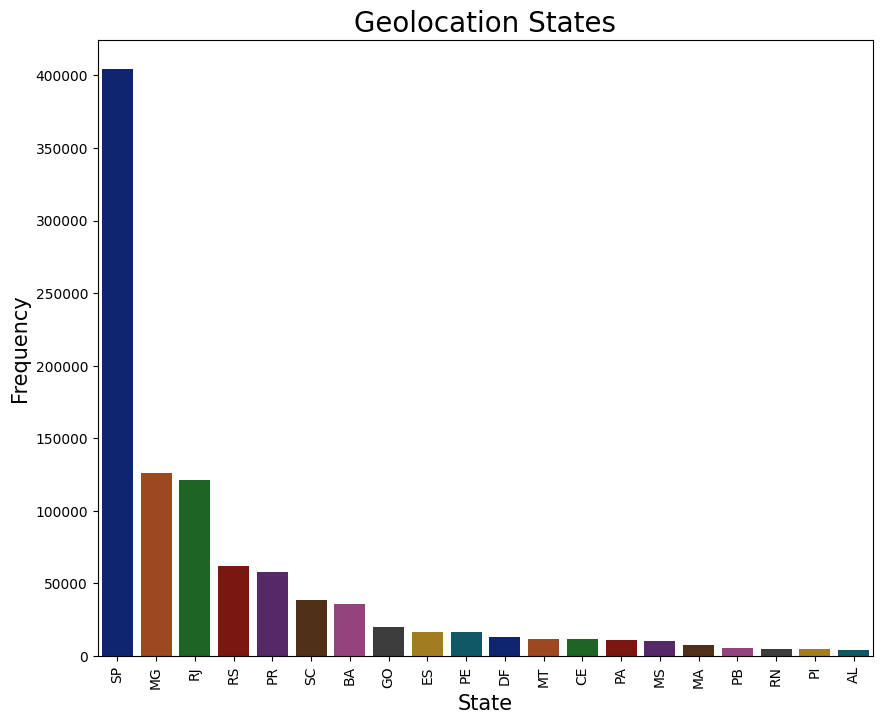

In [ ]:
plt.figure(figsize=(10,8))
x = top_20_geo_states.index
y = top_20_geo_states.values
sns.barplot(x=x, y=y, palette='dark')
plt.xticks(rotation='vertical')
plt.title('Geolocation States', fontsize=20)
plt.xlabel('State', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

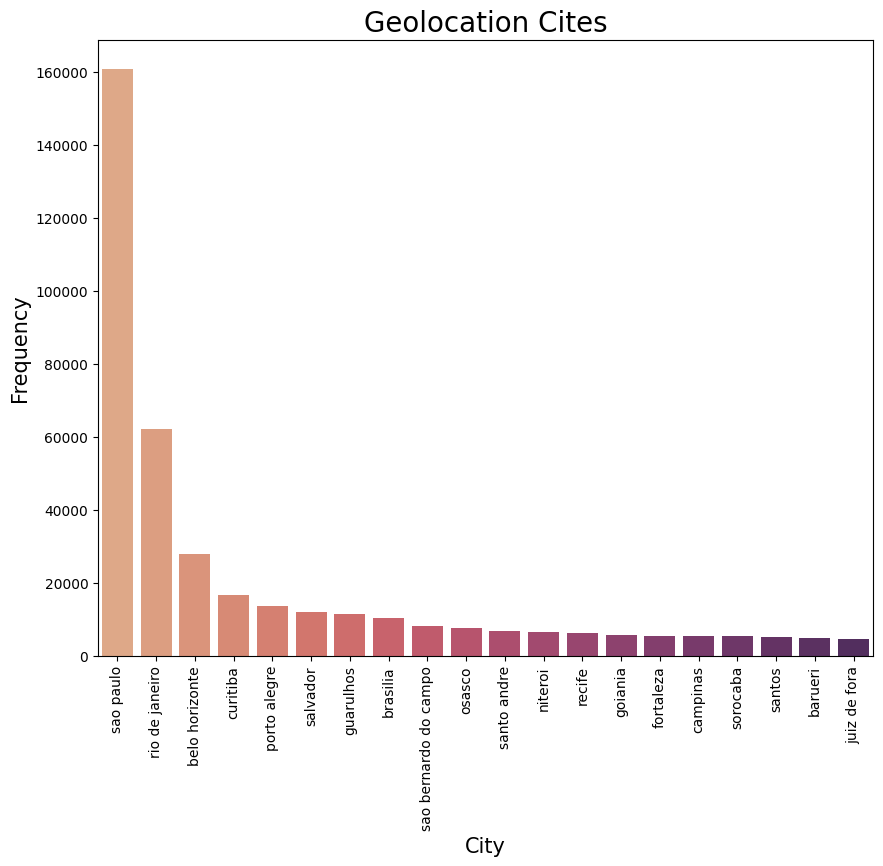

In [ ]:
plt.figure(figsize=(10,8))
x = top_20_geo_cities.index
y = top_20_geo_cities.values
sns.barplot(x=x, y=y, palette='flare')
plt.xticks(rotation='vertical')
plt.title('Geolocation Cites', fontsize=20)
plt.xlabel('City', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

In [ ]:
pie_geolocation_city=geolocation[geolocation['geolocation_city'].isin(geolocation['geolocation_city'].value_counts(ascending=False).index[:20])]
print(pie_geolocation_city['geolocation_city'].value_counts().reset_index())
px.pie(pie_geolocation_city['geolocation_city'].value_counts().reset_index(),
      values=pie_geolocation_city['geolocation_city'].value_counts().reset_index()['geolocation_city'],
      names=pie_geolocation_city['geolocation_city'].value_counts().index,
      hole=0.3)

                    index  geolocation_city
0               sao paulo            160718
1          rio de janeiro             62151
2          belo horizonte             27805
3                curitiba             16593
4            porto alegre             13521
5                salvador             11865
6               guarulhos             11340
7                brasilia             10470
8   sao bernardo do campo              8112
9                  osasco              7658
10            santo andre              6863
11                niteroi              6534
12                 recife              6168
13                goiania              5661
14              fortaleza              5538
15               campinas              5479
16               sorocaba              5361
17                 santos              5000
18                barueri              4971
19           juiz de fora              4679


In [ ]:
geolocation['harvesine_distance'] = [haversine_distance(sp_lat, sp_lon, x, y) 
                              for x, y in zip(geolocation.geolocation_lat.astype(float), geolocation.geolocation_lng.astype(float))]

In [ ]:
geolocation

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,harvesine_distance
0,1037,-23.545621,-46.639292,sao paulo,SP,1604.114832
1,1046,-23.546081,-46.644820,sao paulo,SP,1603.797639
2,1046,-23.546129,-46.642951,sao paulo,SP,1603.897707
3,1041,-23.544392,-46.639499,sao paulo,SP,1604.146824
4,1035,-23.541578,-46.641607,sao paulo,SP,1604.131155
...,...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS,1164.505824
1000159,99900,-27.877125,-52.224882,getulio vargas,RS,1157.846609
1000160,99950,-28.071855,-52.014716,tapejara,RS,1164.193601
1000161,99980,-28.388932,-51.846871,david canabarro,RS,1165.147681


In [ ]:
sao_paolo_map = folium.Map(location=[sp_lat, sp_lon], zoom_start=11)

marker_cluster = folium.plugins.MarkerCluster().add_to(sao_paolo_map)
for lat, lng, in zip(geolocation.geolocation_lat, geolocation.geolocation_lng):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

sao_paolo_map

In [ ]:
sao_paolo_map

### Les commandes clients

In [18]:
# olist_orders_dataset
orders = pd.read_csv( "/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_orders_dataset.csv")
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Ce fichier regroupe les entêtes de commandes, identifiées par un order_id unique et rattaché à un client par le customer_id.

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [20]:
orders.shape

(99441, 8)

In [21]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

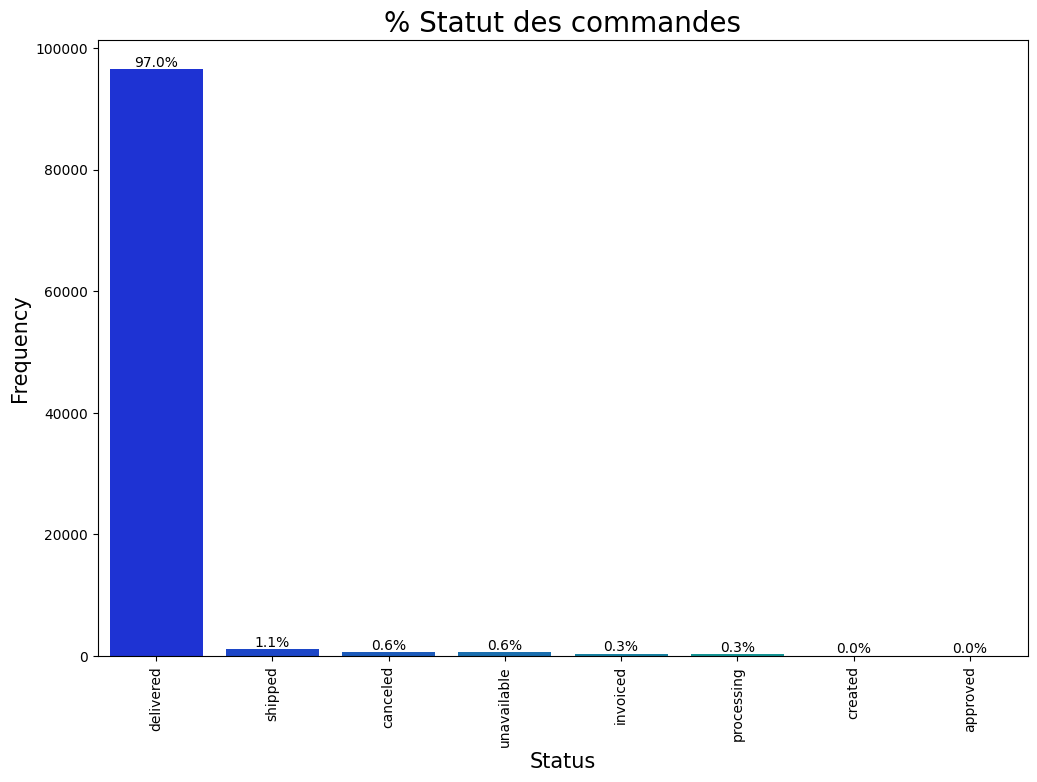

In [ ]:
x = orders['order_status']
order =orders['order_status'].value_counts().index
count_plot(x, orders, "% Statut des commandes", "Status", 'Frequency', 12, 8, order =order, rotation=True)

### Les articles

In [22]:
# olist_order_items_dataset
order_items = pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_order_items_dataset.csv")
order_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [23]:
order_items.shape

(112650, 7)

In [24]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [25]:
order_items.duplicated().mean()

0.0

Variables importantes du dataset regroupant les lignes de commande :

* order_id : Identifiant unique de la commande
* order_item_id : Identifiant séquentiel des items d'une même commande (lignes de commande)
* product_id : Identifiant unique du produit
* seller_id : Identifiant unique du vendeur
* price : Prix de la ligne de commande
* freight_value : Coût de fret de la ligne (Si plusieurs lignes, le coût de fret est réparti entre   toutes les lignes)

In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


### Les paiements

In [26]:
# olist_order_payments_dataset
order_payments = pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_order_payments_dataset.csv")
order_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


* payment_sequential : Si plusieurs méthodes de paiement appliquées, une ligne est crée par moyen     utilisé.
* payment_installments : Nombre de versements choisis

In [ ]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [28]:
order_payments.shape

(103886, 5)

In [29]:
order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [30]:
order_payments.duplicated().mean()

0.0

### Avis clients

In [31]:
# olist_order_reviews_dataset
order_reviews = pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_order_reviews_dataset.csv")
order_reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [32]:
order_reviews.shape

(99224, 7)

In [33]:
order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [34]:
order_reviews.duplicated().mean()

0.0

Ce dataset porte sur les avis clients liés à une commande. Il comporte une note et un commentaire.

### Les produits

In [35]:
# olist_products_dataset
products = pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_products_dataset.csv")
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [36]:
products.shape

(32951, 9)

Ce dataset regroupe les catégories de produits ainsi que diverses caractéristiques de dimensions et poids.

In [37]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [38]:
products.duplicated().mean()

0.0

### Les vendeurs

In [39]:
# olist_sellers_dataset
sellers =   pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist_sellers_dataset.csv")
sellers.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [ ]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [40]:
sellers.shape

(3095, 4)

In [41]:
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [42]:
sellers.duplicated().mean()

0.0

### Categories traduites

In [43]:
# olist_product_category_name_translation_dataset
categories_en = pd.read_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/product_category_name_translation.csv")
categories_en.head(5)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
categories_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [44]:
categories_en.shape

(71, 2)

In [46]:
categories_en.isnull().sum()

product_category_name            0
product_category_name_english    0
dtype: int64

In [47]:
categories_en.duplicated().mean()

0.0

Les catégories traduites et les produits sont liés par la variable product_category_name. Les vendeurs n'étant pas l'objet de cette analyse, le dataset correspondant sera ici ignoré.

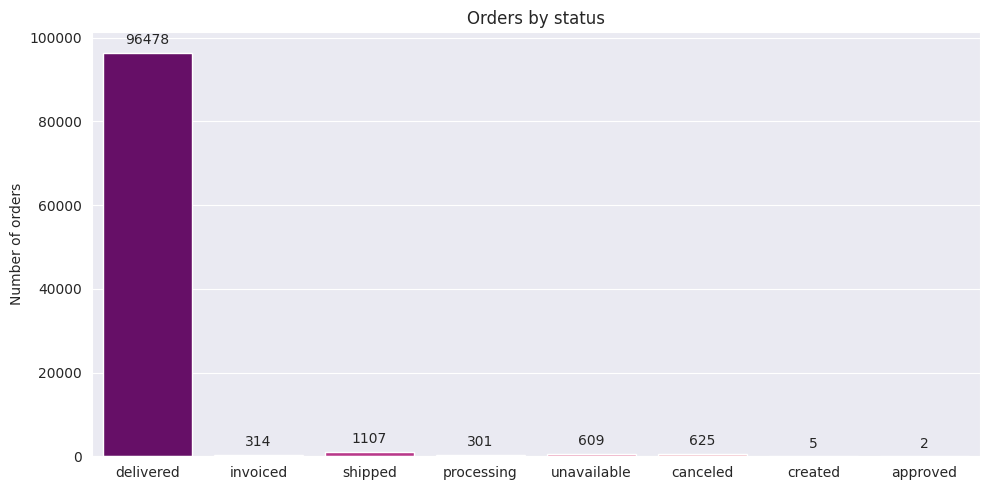

In [ ]:
# Setting a style
sns.set_style('darkgrid')

# Creating a plot to show number of orders by order_status
fig, ax = plt.subplots(figsize = (10, 5))

sns.countplot(ax = ax, x = 'order_status', data = orders, palette = 'RdPu_r').set(xlabel = None)
ax.bar_label(ax.containers[0], padding = 4)
plt.title('Orders by status')
plt.ylabel('Number of orders')

plt.tight_layout()

# Création des datasets étendus

### Produits et catégories

Nous allons à présent créer des dataset plus complets en réalisant des jointures sur les produits 

et catégories dans un premier temps, tout en supprimant les variables qui seront inutiles dans 


In [ ]:
products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

del_features_list = ["product_category_name", "product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]
products.drop(del_features_list, axis=1, inplace=True)
products = products.rename(columns={"product_category_name_english":
                                    "product_category_name"})
products.head(6)

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,housewares
5,41d3672d4792049fa1779bb35283ed13,60.0,745.0,1.0,musical_instruments


Nous pouvons visualiser la répartition des diverses catégories de produits 

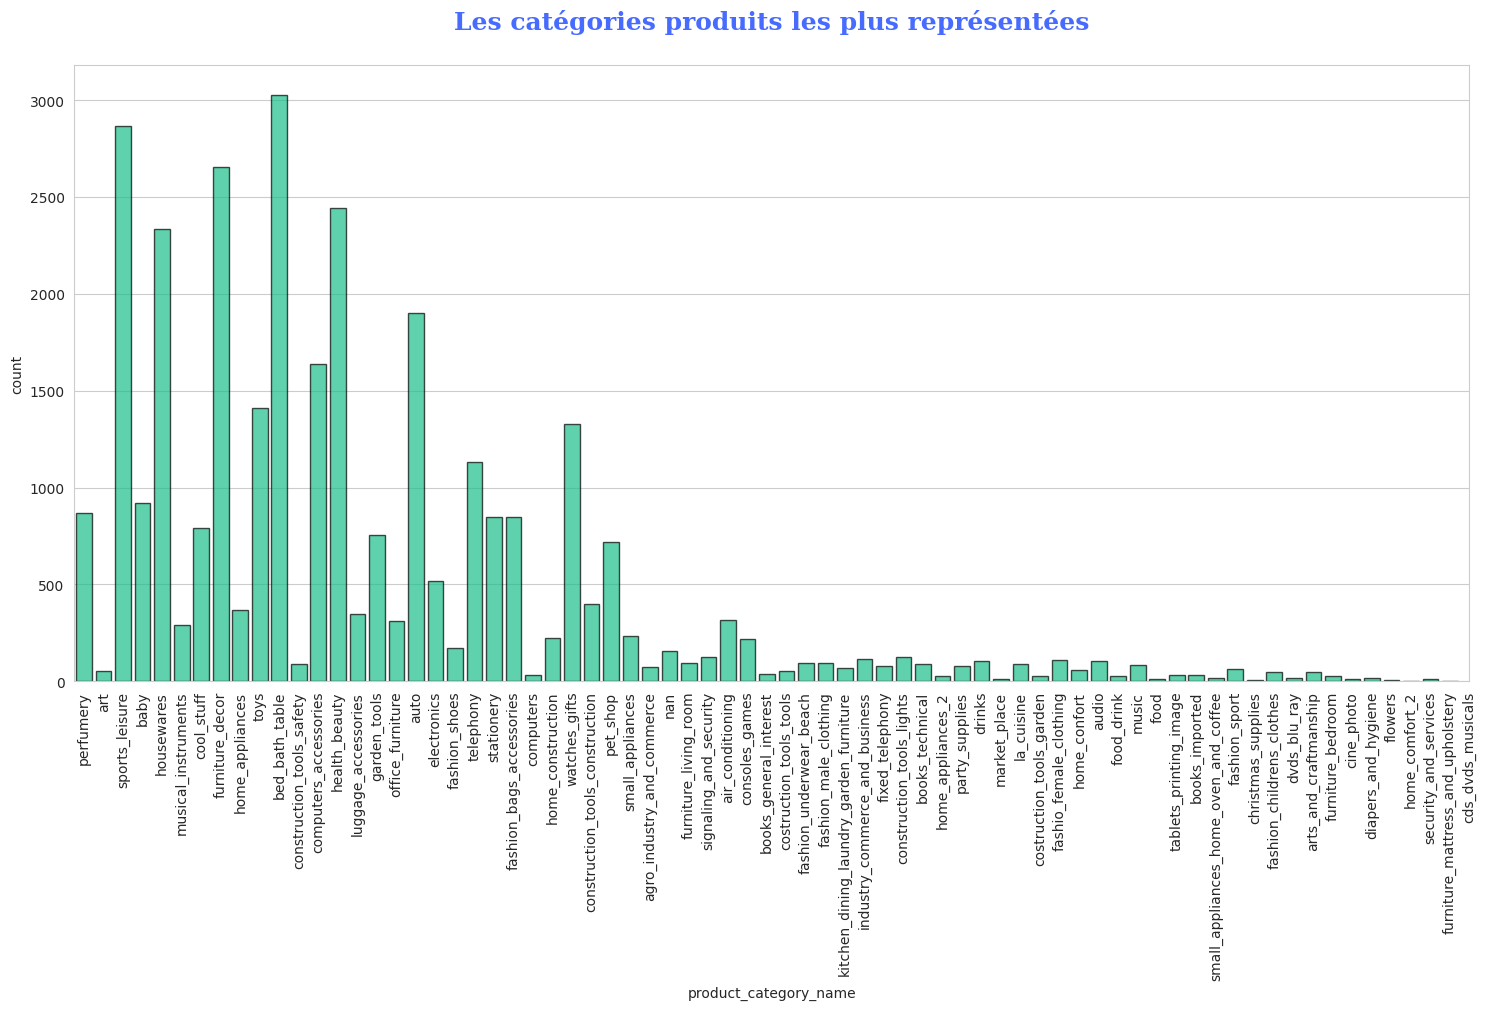

In [ ]:
# Plot categories count in dataset
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=products, x="product_category_name",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, products["product_category_name"].nunique()+1),
           products["product_category_name"].unique(),
           rotation=90)
plt.title(f"Les catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

### Commandes et clients

Nous allons regrouper les données de lignes de commandes, d'entêtes de commandes et de données clients dans un unique dataframe.

In [ ]:
order_items = pd.merge(order_items, orders,
                       how="left",
                       on="order_id")

del_features_list = ["seller_id", "shipping_limit_date",
                     "order_approved_at",
                     "order_delivered_carrier_date",
                     "order_estimated_delivery_date"]
order_items.drop(del_features_list,
                 axis=1,
                 inplace=True)
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31


Regardons les différents statuts de commande pour ne conserver que les commandes qui ne sont pas "en cours".

In [ ]:
order_items.groupby(by="order_status").sum()["order_item_id"]

<ipython-input-42-4324cb129f66>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

Nous conserverons les lignes typées "delivered".

In [ ]:
order_items = order_items[order_items["order_status"] == "delivered"]

In [ ]:
order_items["order_status"].unique()

array(['delivered'], dtype=object)

Nous pouvons également vérifier l'évolution du nombre de commandes passées par jour sur le site E-Commerce :

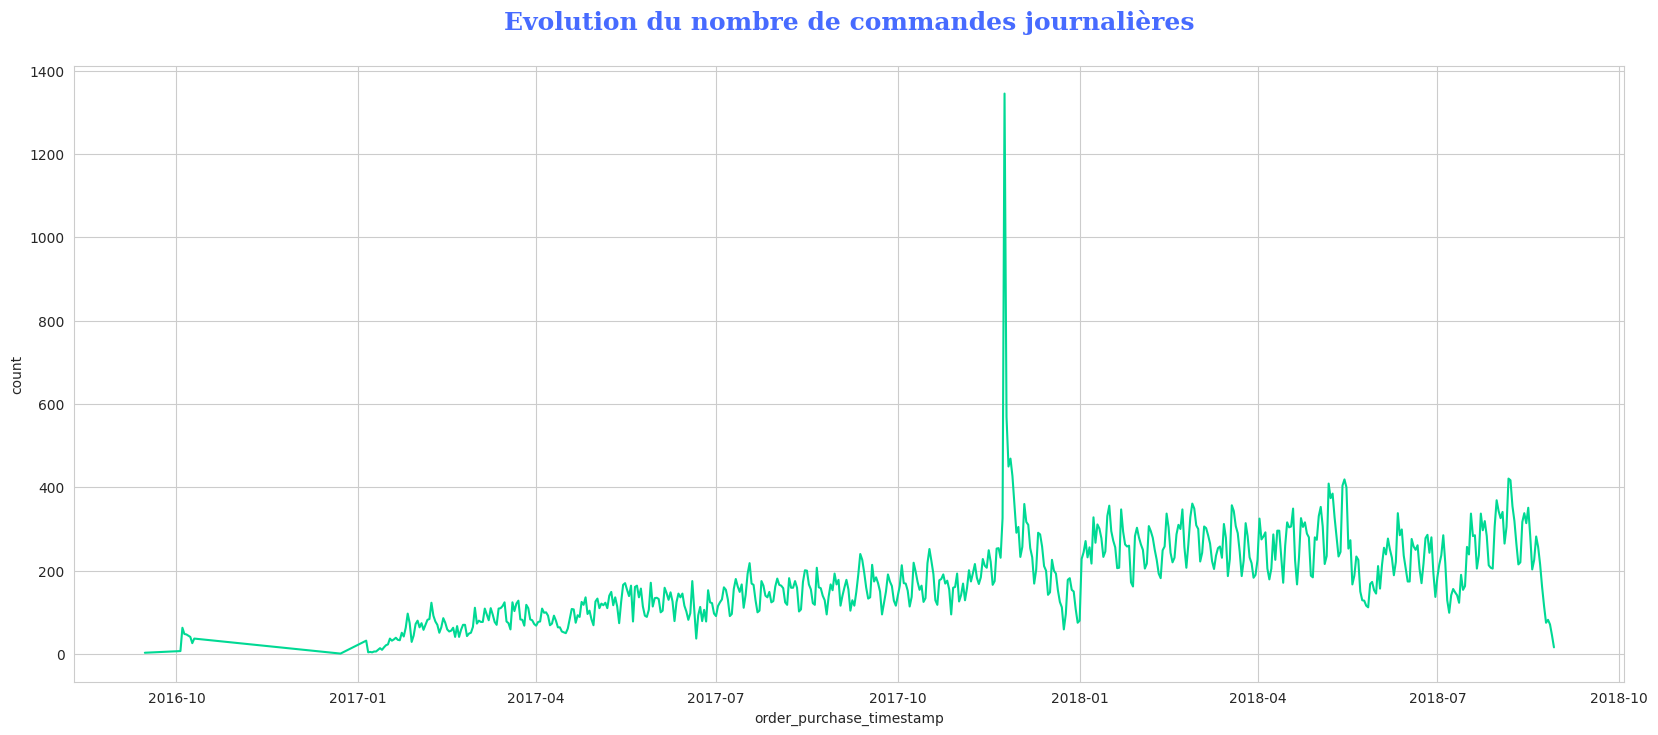

In [ ]:
orders_per_days = order_items.groupby(order_items["order_purchase_timestamp"]\
                                      .astype('datetime64[ns]').dt.date)\
                                    .count()["order_id"]
fig = plt.figure(figsize=(20, 8))
ax = orders_per_days.plot(color="#00d994")
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de commandes journalières\n",
          fontdict=font_title)
plt.show()

nous remarquon un pic vers la fin d'année

Nous allons modifier les types de données en datetime pour les colonnes temporelles.

In [ ]:
# Modify object cols in timestamp format
datetime_cols = ["order_purchase_timestamp", "order_delivered_customer_date"]
for col in datetime_cols:
    order_items[col] = order_items[col].astype('datetime64[ns]')
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 8.4+ MB


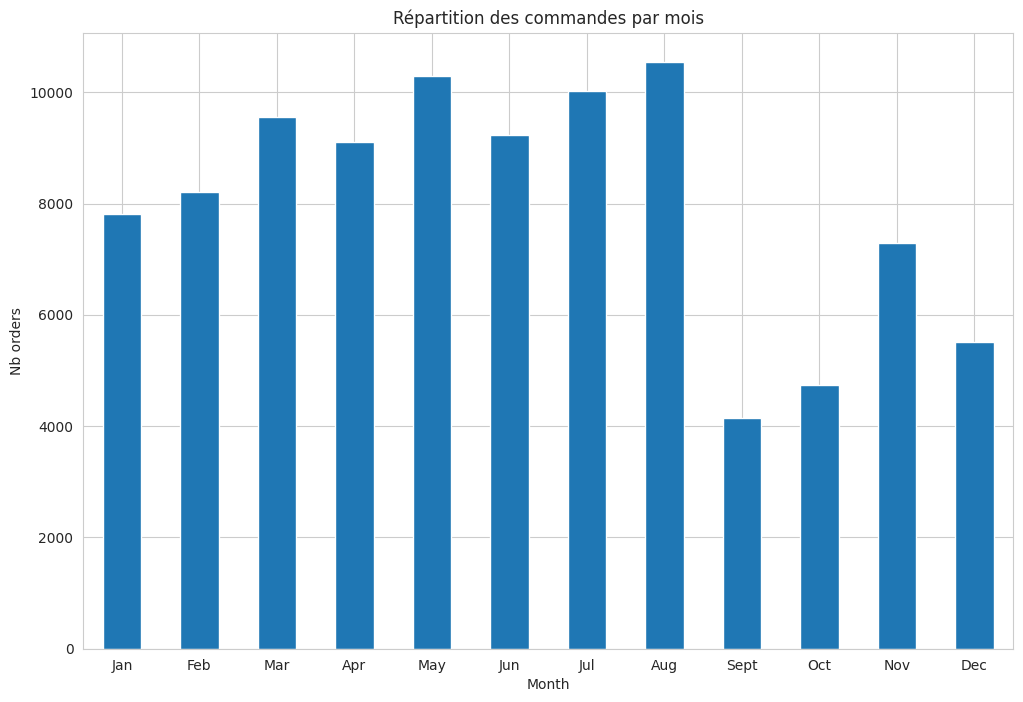

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="Month",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sept','Oct','Nov','Dec'], 
           rotation='horizontal')
plt.show()

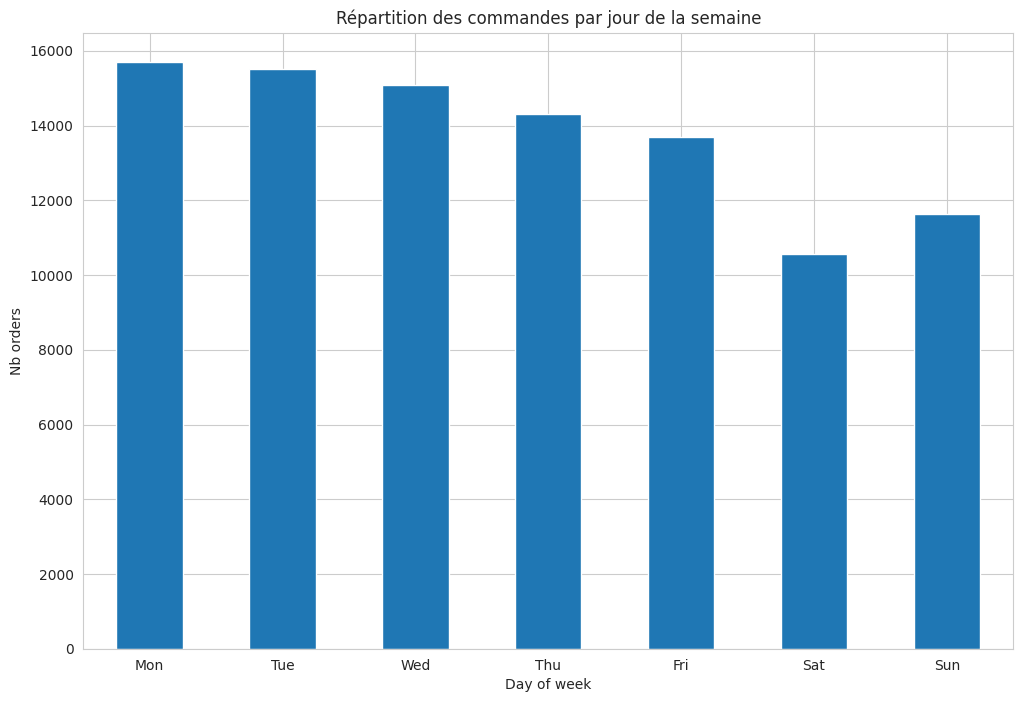

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.dayofweek)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par jour de la semaine",
          ylabel="Nb orders",
          xlabel="Day of week",
          legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation='horizontal')
plt.show()

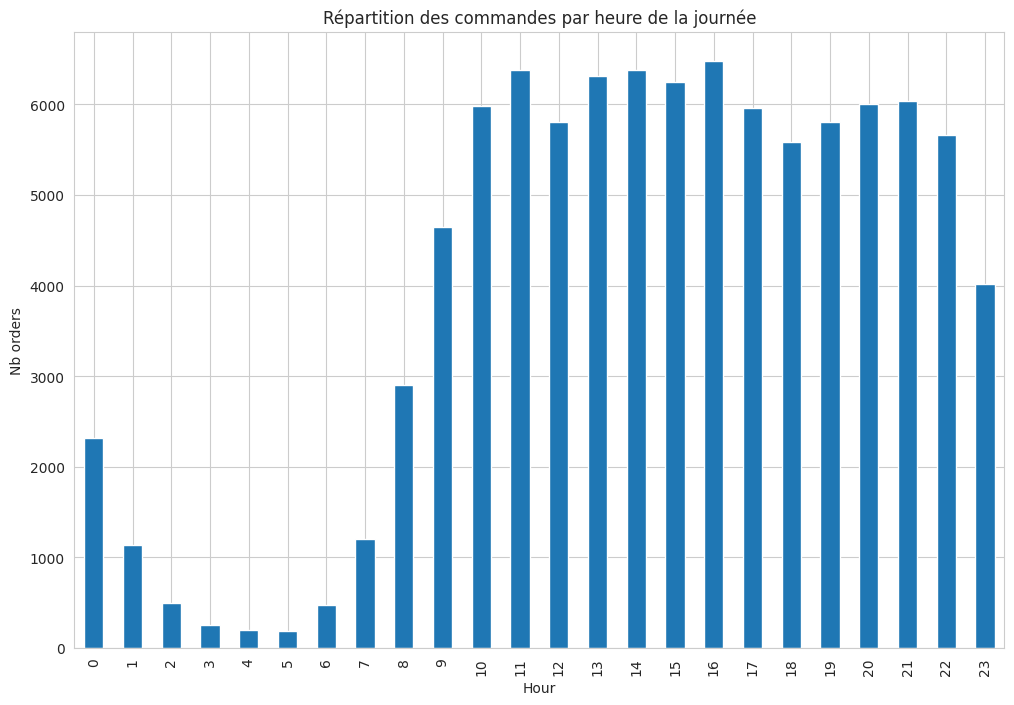

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par heure de la journée",
          ylabel="Nb orders",
          xlabel="Hour",
          legend=False)
plt.show()

On remarque les plus gros écart sur les données mensuelles. Vérifions les variances de chiffre d'affaire sur les mois de l'années

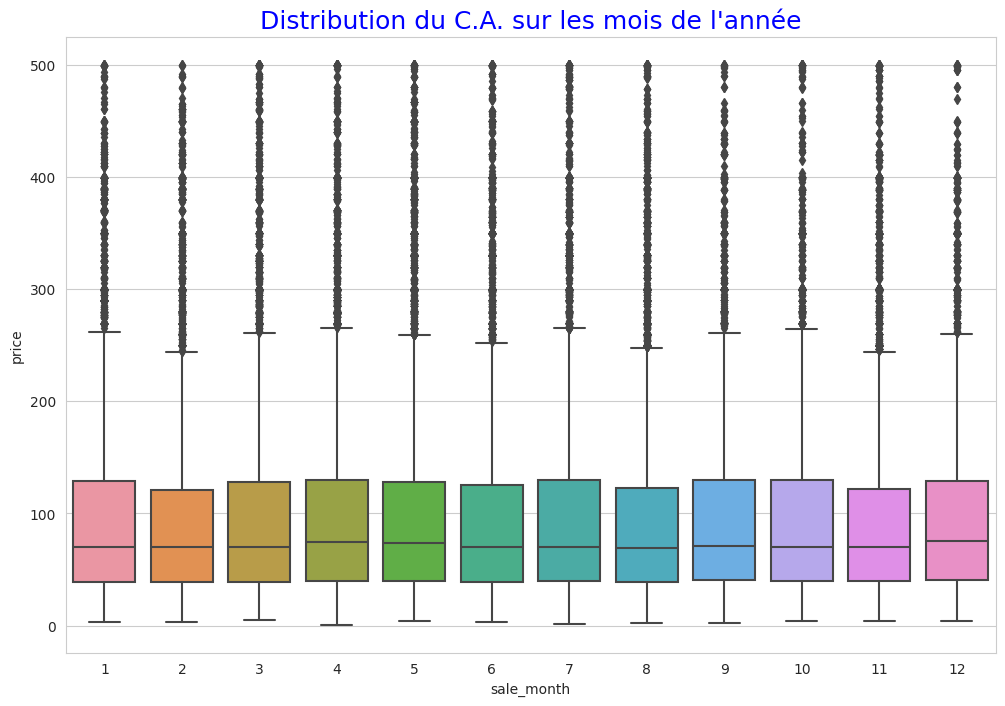

In [ ]:
order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items[order_items.price < 500], x="sale_month", y="price")
plt.title("Distribution du C.A. sur les mois de l'année", fontsize=18, color="b")
plt.show()

Les médianes et variances restent très proche sur les différents mois de l'année. Nous intégrerons tout de même cette donnée pour le moment mais il sera judicieux de regarder l'évolution de cette distribution pour l'intégrer dans le cadre du contrat de maintenance.

Pour le dataset des paiements, vous allons créer de nouvelles variables à savoir :

* Le nombre de moyens de paiement différents utilisés sur la commande.
* Le nombre d'échéances totales de la commande.

In [ ]:
group_payments = order_payments.groupby(by="order_id").agg(
    {"payment_sequential": 'count',
     "payment_installments": 'sum'})

order_items = pd.merge(order_items, group_payments,
                       how="left",
                       on="order_id")
order_items = order_items.rename(columns={
    "payment_sequential": "nb_payment_sequential",
    "payment_installments": "sum_payment_installments"})
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0


Nous allons également vérifier la répartition des moyens de paiement utilisés pour décider si cette information est importante ou non dans les analyses :

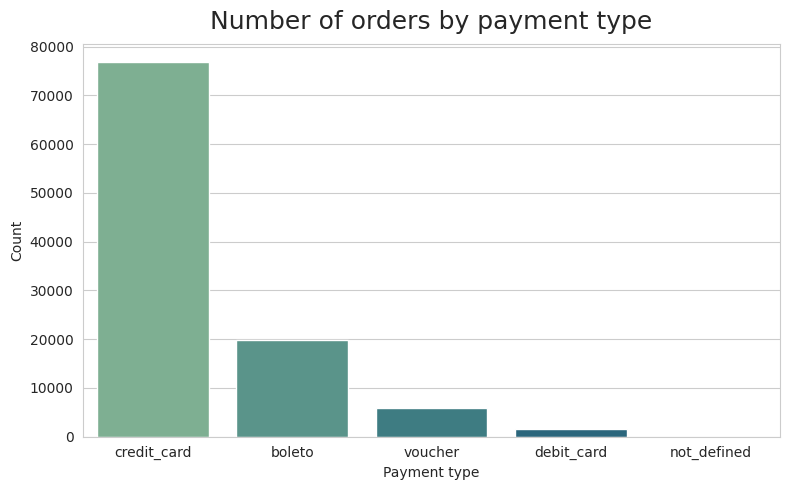

In [ ]:
plt.figure(figsize = (8, 5))

sns.countplot(x = 'payment_type', data = order_payments, palette = 'crest')
plt.title('Number of orders by payment type', fontdict = {'fontsize': 18}, pad = 10.5)
plt.xlabel('Payment type')
plt.ylabel('Count')

plt.tight_layout()

On remarque que 80% des paiements environ sont réalisés en carte bancaire. Nous ne prendrons donc pas en considération cette variable dans nos explorations.

Pour les avis clients, nous allons également créer une nouvelle variable qui indiquera seulement si oui ou non la commande a été notée (True or False) et une seconde variable qui reprendra la note attribuée.

In [ ]:
group_reviews = order_reviews.groupby("order_id").agg({
                                                         "review_id": "count",
                                                         "review_score": "mean"})

order_items = pd.merge(order_items, group_reviews,
                       how="left",
                       on="order_id")
order_items = order_items.rename(columns={
                                           "review_id": "is_reviewed"})
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0,1.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0,1.0,4.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0,1.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0,1.0,5.0


In [ ]:
order_items["is_reviewed"] = np.where(order_items["is_reviewed"] == 1,
                                          True, False)

Nous pouvons à présent projeter la répartion des notes attribuées aux commandes du site :

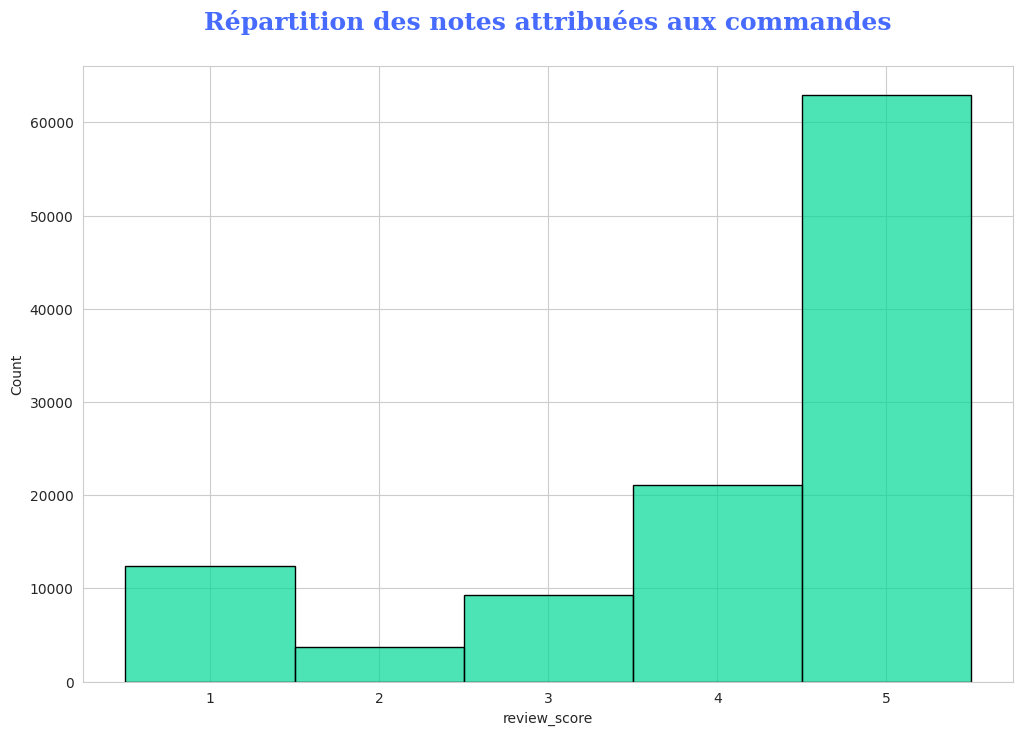

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=order_items, x="review_score", 
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.title(f"Répartition des notes attribuées aux commandes\n",
          fontdict=font_title)
plt.show()

Il nous reste à réaliser la jointure sur le fichier clients :

In [ ]:
order_items = pd.merge(order_items, customers,
                       how="left",
                       on="customer_id")
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0,True,5.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0,True,4.0,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0,True,5.0,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0,True,4.0,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0,True,5.0,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [ ]:
order_items.shape

(110197, 18)

et enfin créer le dataset global en réalisant la jointure avec les produits / catégories :

In [ ]:
data = pd.merge(order_items, products,
                how="left",
                 on="product_id")
data.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,...,is_reviewed,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,...,True,5.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,58.0,598.0,4.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,...,True,4.0,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,56.0,239.0,2.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,...,True,5.0,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,59.0,695.0,2.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,...,True,4.0,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,42.0,480.0,1.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,...,True,5.0,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,59.0,409.0,1.0,garden_tools


In [ ]:
data.to_csv('/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/data1.csv', index=False)

In [ ]:
data["delivery_delta_days"] = (data.order_delivered_customer_date
                               - data.order_purchase_timestamp)\
                              .dt.round('1d').dt.days
data.drop("order_delivered_customer_date", axis=1, inplace=True)

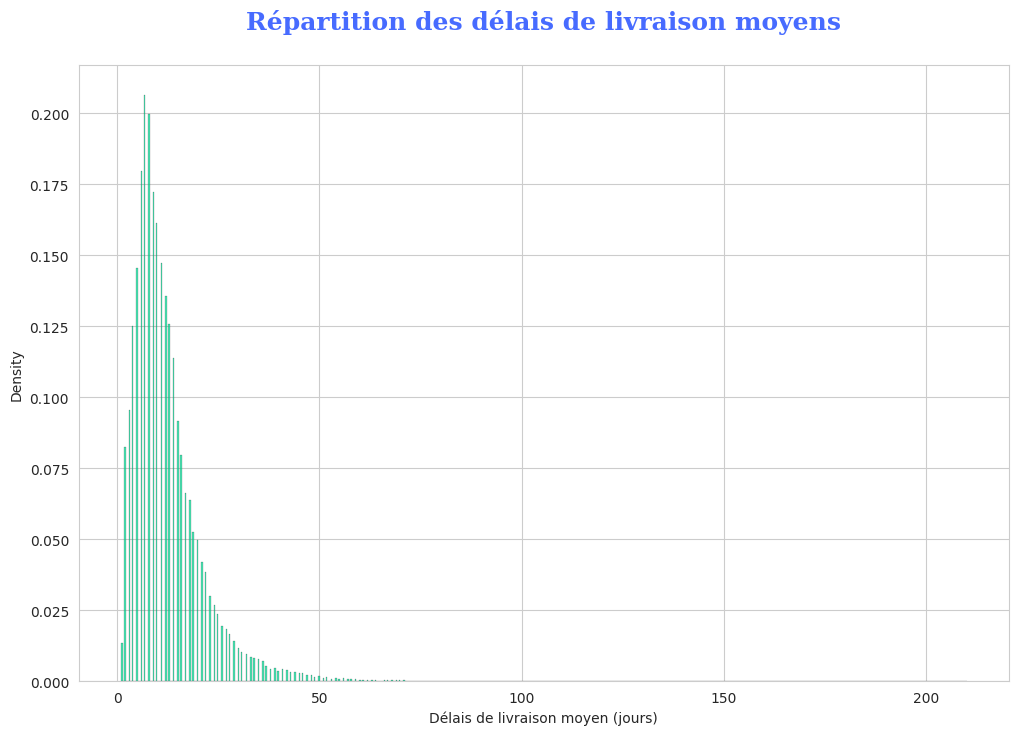

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="delivery_delta_days",
             stat="density",
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Délais de livraison moyen (jours)")
plt.title(f"Répartition des délais de livraison moyens\n",
          fontdict=font_title)
plt.show()

Autre variable à créer, la catégorie de produit de niveau 1. En effet, le jeu de données compte plus de 70 catégories différentes (ce qui peut poser problème pour un encodage lors des preprocessing). Nous allons donc devoir regrouper plusieurs de ces catégorie dans une catégorie de niveau supérieur.

Pour cela, nous allons nous baser sur les catégories principales des sites de vente en ligne en 2017, disponibles sur le site http://statista.com :

* Fashion, clothing and accessories
* Health and Beauty
* Toys and baby equipment
* Books, CDs and other physical media
* Groceries, food and drink
* Technology (including phones and computers)
* Home and furniture
* Flowers and gifts
* Other
* et nous ajoutons la catégorie sport
Nous allons devoir les attribuer manuellement :

In [ ]:
data['product_category'] = np.where((data['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((data['product_category_name'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((data['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((data['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((data['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((data['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((data['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((data['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((data['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

In [ ]:
# drop product_category_name column
data.drop("product_category_name", axis=1, inplace=True)

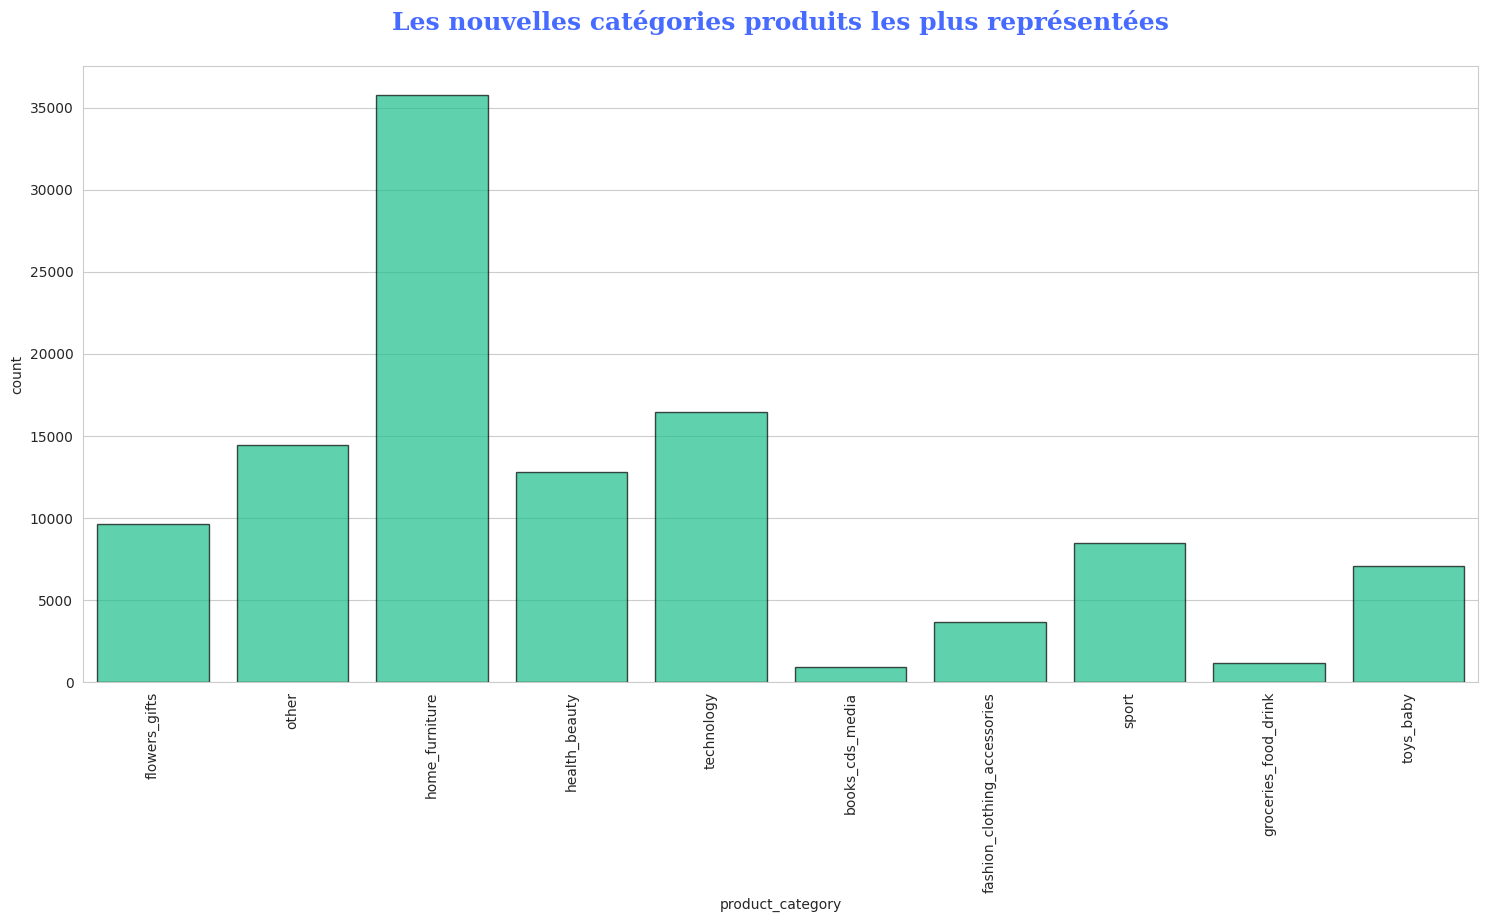

In [ ]:
# Plot categories count in dataset
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data, x="product_category",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, data["product_category"].nunique()),
           data["product_category"].unique(),
           rotation=90)
plt.title(f"Les nouvelles catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

A présent, nous pouvons regarder la répartition du nombre de commandes moyen par client :

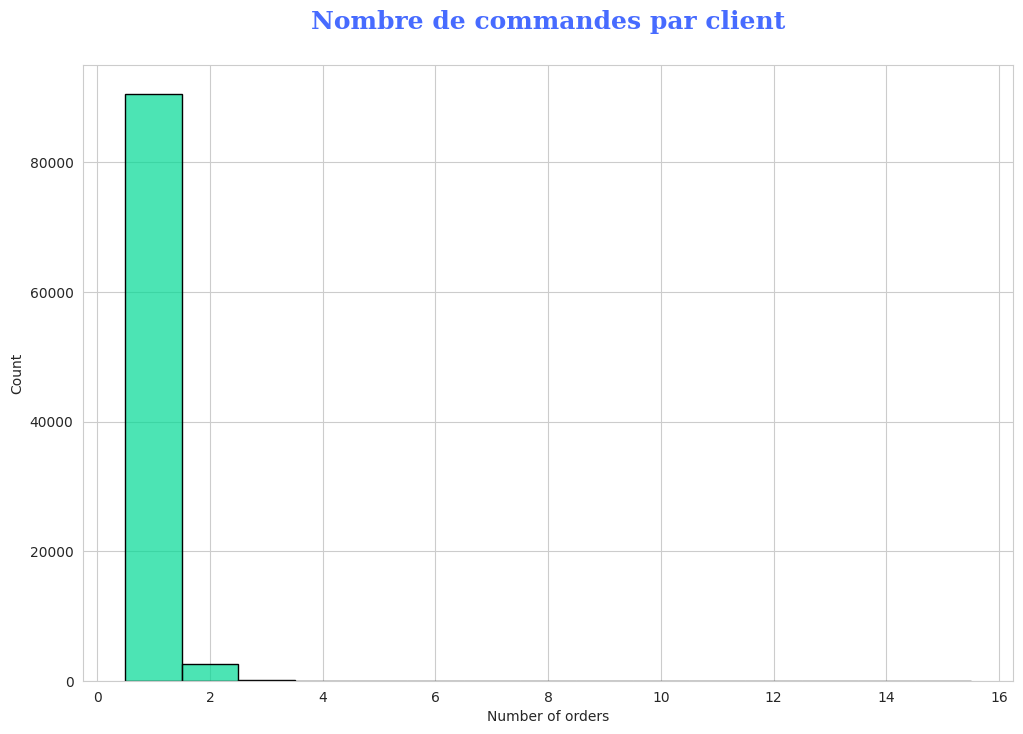

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data.groupby("customer_unique_id").agg({"order_id": "nunique"}),
             x="order_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of orders")
plt.title(f"Nombre de commandes par client\n",
          fontdict=font_title)
plt.show()

La majeure partie des clients n'ont passé qu'une seule commande. Il sera donc compliqué d'établir un classement de leur catégorie produit préférée. Nous allons donc créer une variable par catégorie produit pour y dispatcher le nombre de produits achetés sur les commandes passées.
Ensuite, nous calculerons le ratio du nombre de produits par catégorie sur le nombre de produits total acheté par le client.

In [ ]:
categories_customers = data.groupby(["customer_unique_id", "product_category"])\
                        .agg({"order_item_id": "count"}).unstack()
categories_customers.columns = categories_customers.columns.droplevel(0)
categories_customers.fillna(0, inplace=True)
categories_customers["total_items"] = categories_customers.sum(axis=1)

# ratio of total items
for col in categories_customers.columns:
    if (col != "total_items"):
        categories_customers[col] = (categories_customers[col]/categories_customers["total_items"])

categories_customers.reset_index(inplace=True)
categories_customers.head(5)

product_category,customer_unique_id,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Nous allons ensuite calculer le nombre moyen d'articles par commande pour chaque client :

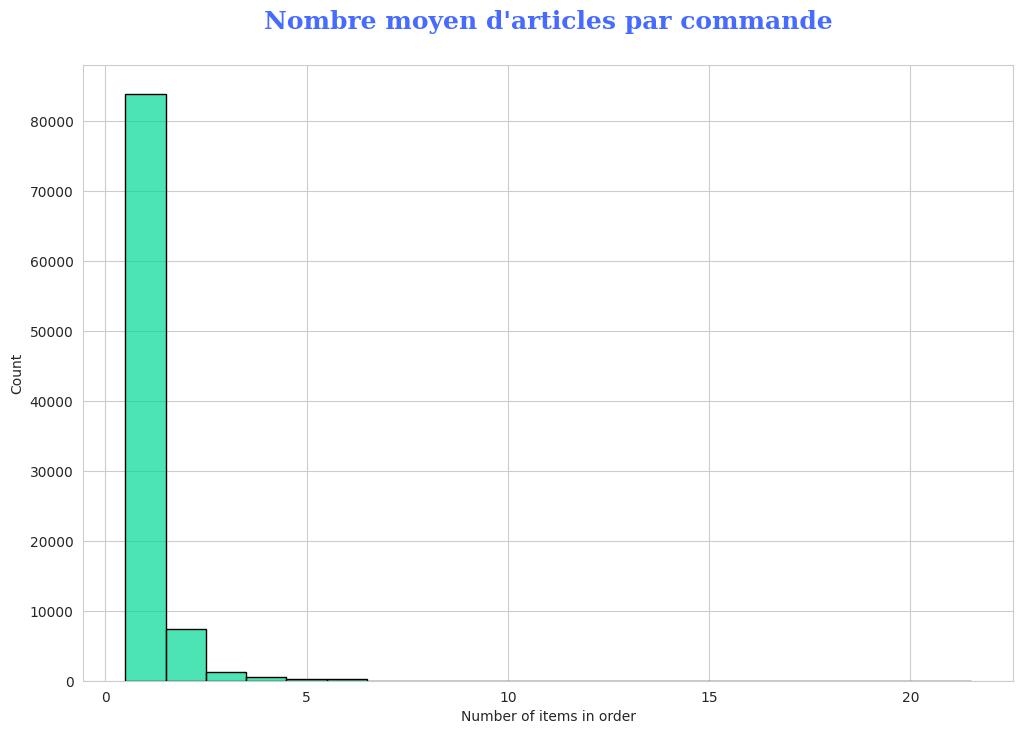

In [ ]:
products_per_order = data.groupby(["customer_unique_id", "order_id"])\
                        .agg({"order_item_id": "count"})
products_per_order = products_per_order.groupby("customer_unique_id")\
                        .agg({"order_item_id": "mean"})

# Plot density of number items in order
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = products_per_order,
             x="order_item_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of items in order")
plt.title(f"Nombre moyen d'articles par commande\n",
          fontdict=font_title)
plt.show()

In [ ]:
data.columns

Index(['order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp', 'sale_month',
       'nb_payment_sequential', 'sum_payment_installments', 'is_reviewed',
       'review_score', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'delivery_delta_days', 'product_category'],
      dtype='object')

A présent, nous allons calculer le nombre de jours écoulés entre la première et la dernière commande. Nous ramènerons ensuite ce délai au nombre de commande du client.

In [ ]:
recurencies = data.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
recurencies.columns = recurencies.columns.droplevel(0)

# Max date in dataset
max_date = data["order_purchase_timestamp"].max()

# Delay from the last order
recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] 
                                    else (max_date - y[0]).days 
                                    for x,y in recurencies.iterrows()]

recurencies.head(5)

,min,max,order_total_delay
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,111
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,114
0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,536
0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,320
0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,287


## Geolocalisation

In [ ]:
customers['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
bequimao                 1
andarai                  1
vargem grande            1
curvelandia              1
eugenio de castro        1
Name: customer_city, Length: 4119, dtype: int64

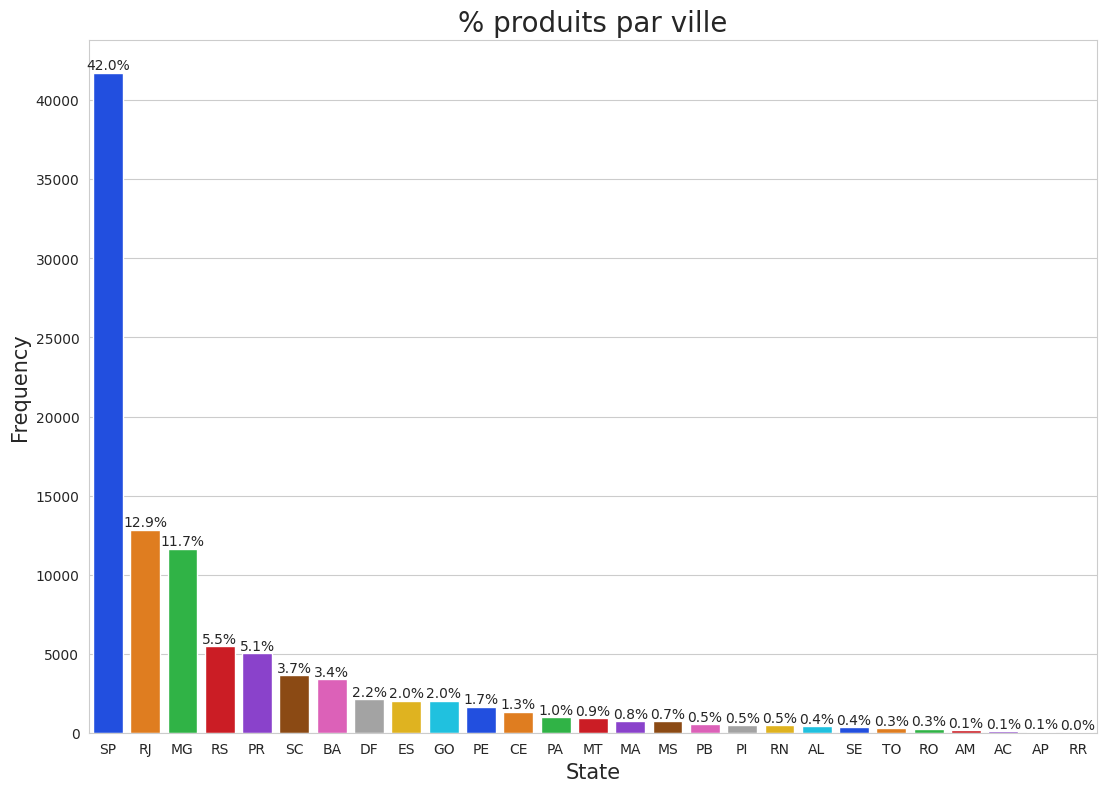

In [ ]:
count_plot(customers['customer_state'], customers, "% produits par ville", "State", 'Frequency', 13, 9, order=customers['customer_state'].value_counts().index, palette='bright')

# Création du dataset clients 

In [ ]:
# Group by customers with sum or mean
data = data.groupby("customer_unique_id")\
            .agg({"order_id": "nunique",
                  "price": "sum",
                  "freight_value": "sum",
                  "sum_payment_installments": "mean", 
                  "review_score": "mean"})

# Rename columns
data = data.rename(columns={"order_id": "nb_orders",
                            "price": "total_spend",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score"})

# Merge with other calculated features
data = pd.merge(data, categories_customers,
                how="left",
                on="customer_unique_id")

data = pd.merge(data, products_per_order,
                how="left",
                on="customer_unique_id")\
        .rename(columns={"order_item_id": "mean_nb_items"})

data = pd.merge(data, recurencies,
                how="left",
                on="customer_unique_id")

data.head(6)

,customer_unique_id,nb_orders,total_spend,freight_value,mean_payment_installments,mean_review_score,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,...,home_furniture,other,sport,technology,toys_baby,total_items,mean_nb_items,min,max,order_total_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,8.0,5.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,114
2,0000f46a3911fa3c0805444483337064,1,69.00,17.22,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,320
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,6.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,287
5,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,12.98,8.0,4.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2018-04-05 19:33:16,2018-04-05 19:33:16,145


In [ ]:
data.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby', 'total_items', 'mean_nb_items', 'min', 'max',
       'order_total_delay'],
      dtype='object')

Comme énnoncé précédement, nous allons ramener le délais des commandes client en fonction du nombre de commandes pour obtenir le délai moyen entre plusieurs achats :

In [ ]:
data["order_total_delay"] = data["order_total_delay"] / data["nb_orders"]
data = data.rename(columns={"order_total_delay": "order_mean_delay"})

In [ ]:
# Select the most frequents values for each customer
customers_info = customers.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
data = pd.merge(data, customers_info,
                how="left",
                on="customer_unique_id")

In [ ]:
data.head(5)

,customer_unique_id,nb_orders,total_spend,freight_value,mean_payment_installments,mean_review_score,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,...,toys_baby,total_items,mean_nb_items,min,max,order_mean_delay,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,8.0,5.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,111.0,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,114.0,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP
2,0000f46a3911fa3c0805444483337064,1,69.00,17.22,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,536.0,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,320.0,914991f0c02ef0843c0e7010c819d642,66812,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,6.0,5.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,287.0,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_unique_id            93358 non-null  object        
 1   nb_orders                     93358 non-null  int64         
 2   total_spend                   93358 non-null  float64       
 3   freight_value                 93358 non-null  float64       
 4   mean_payment_installments     93357 non-null  float64       
 5   mean_review_score             92755 non-null  float64       
 6   books_cds_media               93358 non-null  float64       
 7   fashion_clothing_accessories  93358 non-null  float64       
 8   flowers_gifts                 93358 non-null  float64       
 9   groceries_food_drink          93358 non-null  float64       
 10  health_beauty                 93358 non-null  float64       
 11  home_furniture              

In [ ]:
data.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby', 'total_items', 'mean_nb_items', 'min', 'max',
       'order_mean_delay', 'customer_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

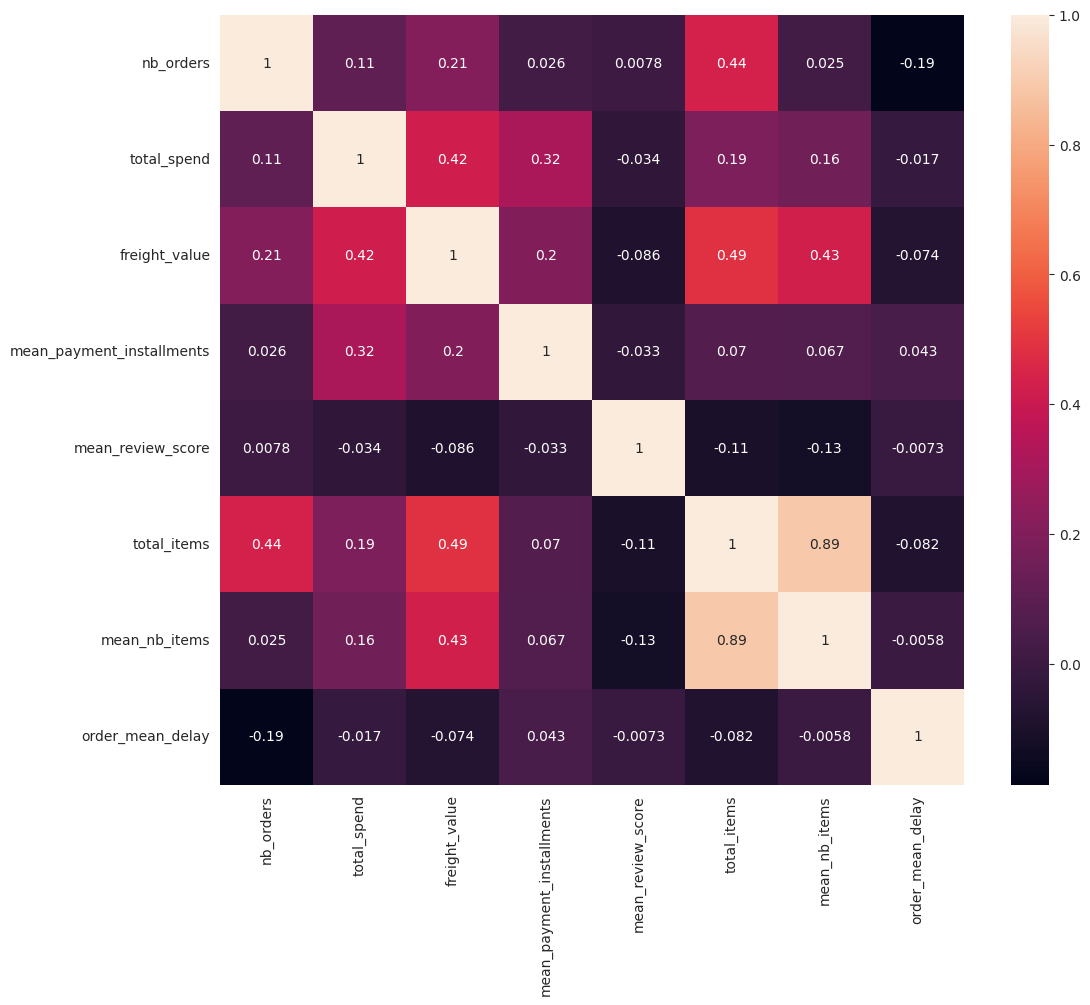

In [ ]:
corr(data[['nb_orders', 'total_spend', 'freight_value','mean_payment_installments'
            , 'mean_review_score','total_items', 'mean_nb_items','order_mean_delay']]
     )

<Axes: >

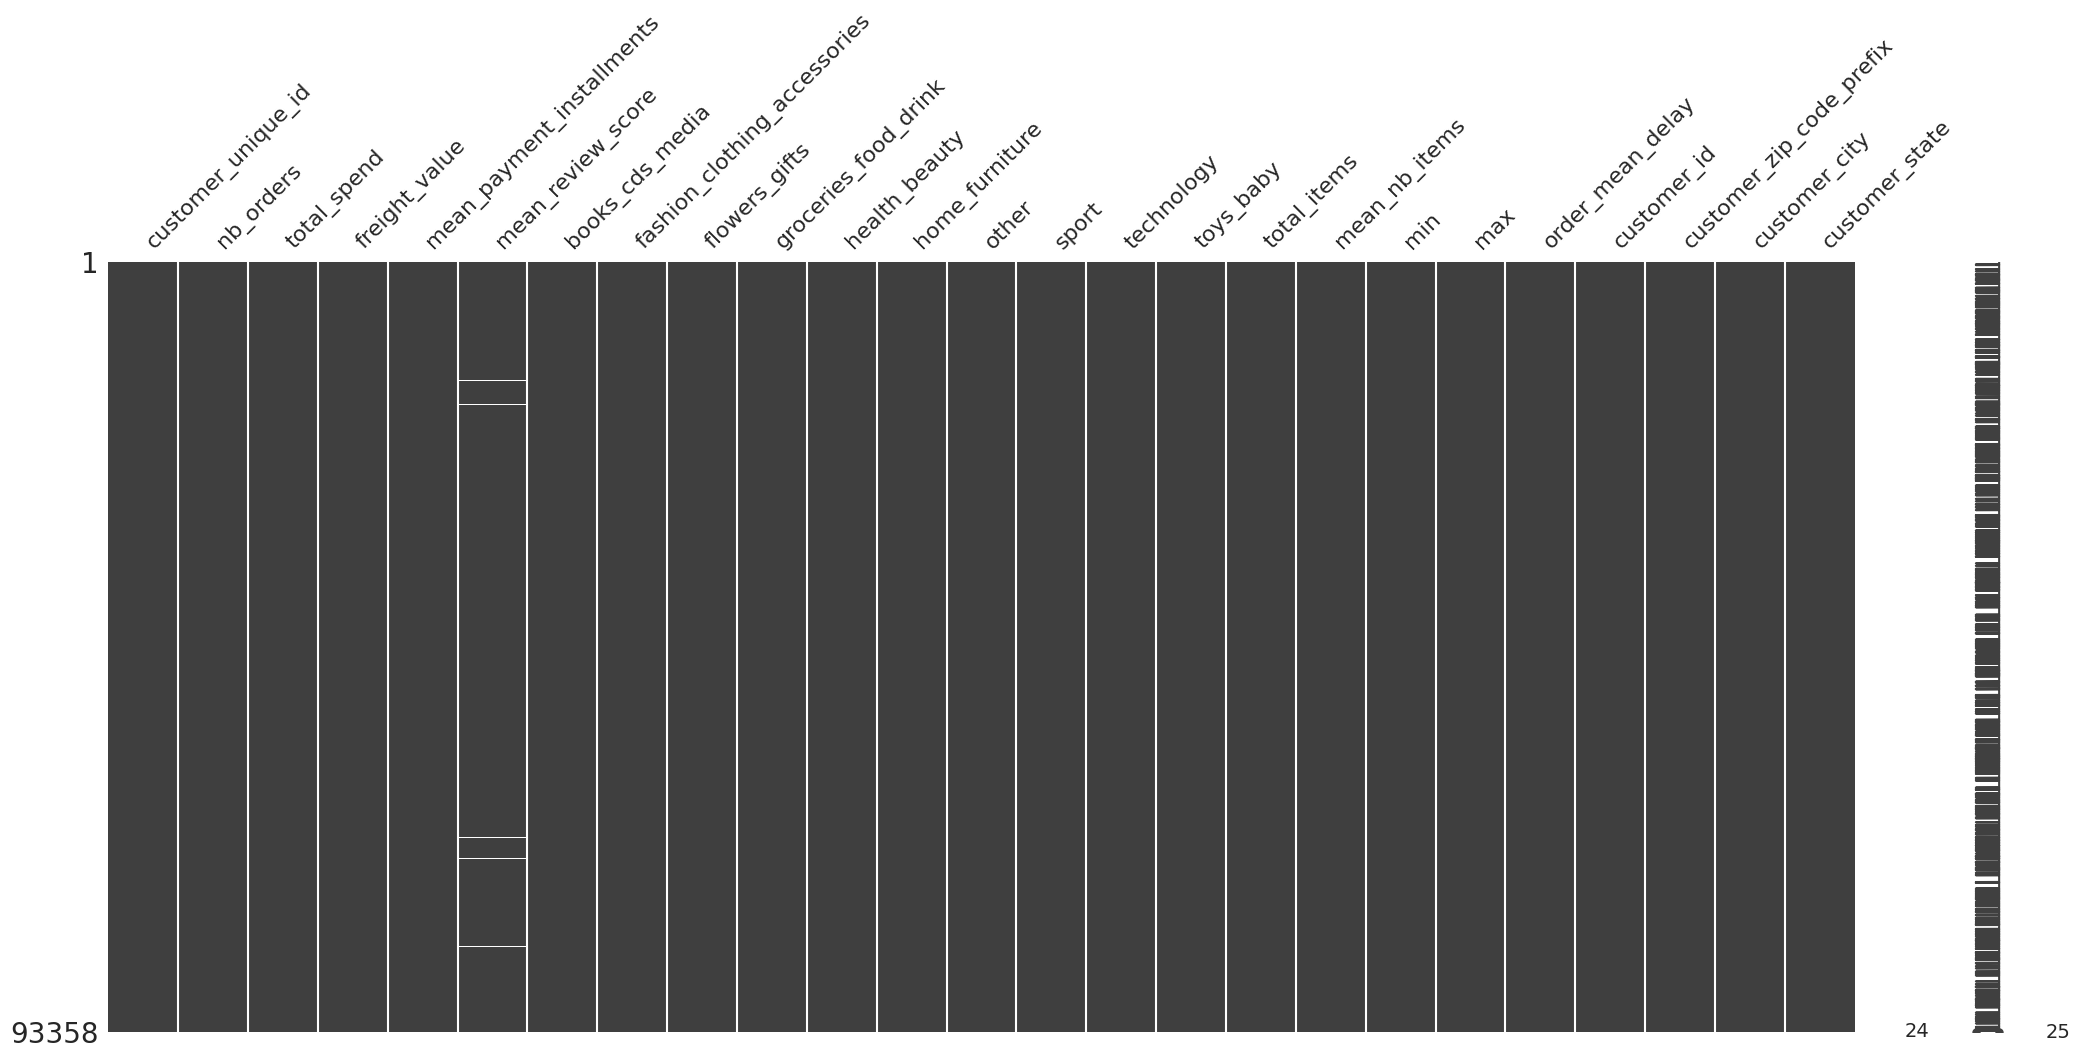

In [ ]:
msn.matrix(data)

Seulement 5 variables contiennent des valeurs manquantes. Nous allons donc les compléter par les valeurs les plus fréquentes :

In [ ]:
# Find features to fill and fillna with mode
features_to_fill = data.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

for f in features_to_fill:
    data[f] = data[f].fillna(data[f].mode()[0])
    print(f, data[f].mode()[0])

mean_payment_installments 1.0
mean_review_score 5.0


In [ ]:
data.describe()

,nb_orders,total_spend,freight_value,mean_payment_installments,mean_review_score,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,mean_nb_items,order_mean_delay,customer_zip_code_prefix
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.033420,141.621480,23.546730,2.965951,4.158806,0.009085,0.034082,0.094412,0.009681,0.121495,0.300037,0.133696,0.077026,0.152034,0.068452,1.180370,1.139531,231.940296,35243.998340
std,0.209097,215.694014,22.780318,2.717719,1.278290,0.094527,0.180035,0.290952,0.097170,0.325329,0.455846,0.338181,0.265228,0.357663,0.251017,0.620857,0.527075,154.162700,29843.212881
min,1.000000,0.850000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1003.000000
25%,1.000000,47.650000,14.070000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,107.000000,11410.000000
50%,1.000000,89.730000,17.600000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,212.000000,24455.000000
75%,1.000000,154.737500,25.520000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,341.000000,59075.000000
max,15.000000,13440.000000,1794.960000,26.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,21.000000,713.000000,99980.000000


On peut voir également dans cette description qu'une commande est chiffrée à plus de 13 000 dollars. Nous allons vérifier cette commande atypique :

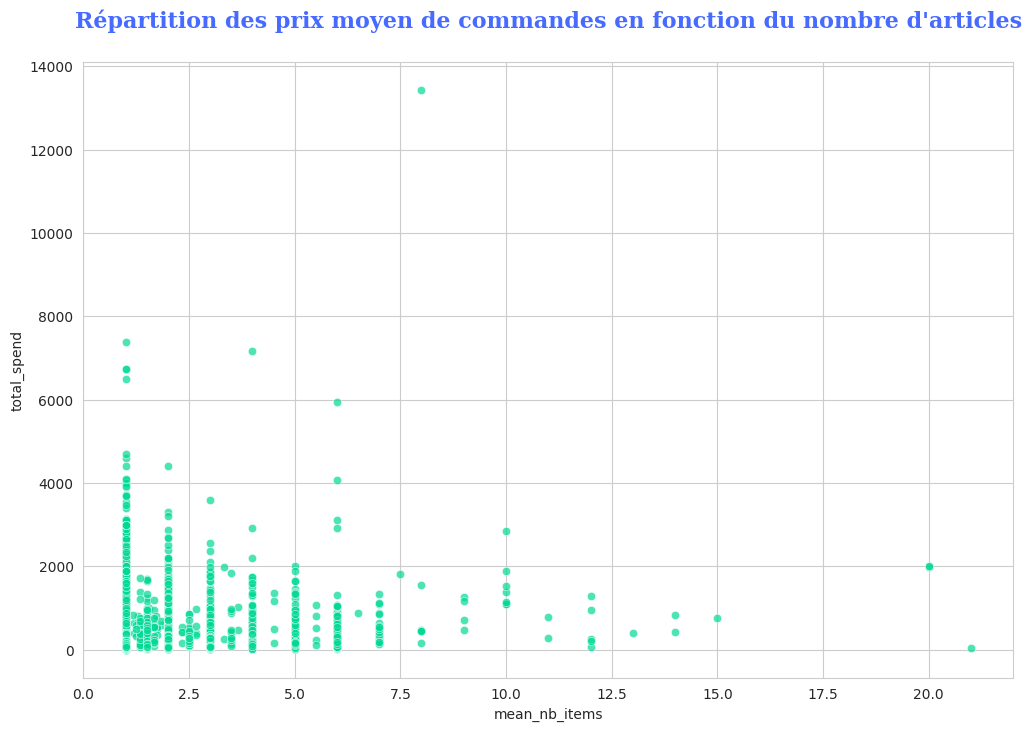

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, y="total_spend", x="mean_nb_items",
                color="#00d994", alpha=0.7)
plt.title(f"Répartition des prix moyen de commandes en fonction du nombre d'articles\n",
          fontdict=font_title, fontsize=16)
plt.show()

Une commande de plus de 20 articles est affichée pour une somme de prêt de 0 :

In [ ]:
pd.set_option('display.max_columns',1000)

In [ ]:
data[data["mean_nb_items"] > 20]

,customer_unique_id,nb_orders,total_spend,freight_value,mean_payment_installments,mean_review_score,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,mean_nb_items,min,max,order_mean_delay,customer_id,customer_zip_code_prefix,customer_city,customer_state
25309,4546caea018ad8c692964e3382debd19,1,31.8,164.37,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.0,21.0,2017-07-16 18:19:25,2017-07-16 18:19:25,408.0,fc3d1daec319d62d49bfb5e1f83123e9,5882,sao paulo,SP


In [ ]:
data[data["total_spend"] > 8000]

,customer_unique_id,nb_orders,total_spend,freight_value,mean_payment_installments,mean_review_score,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,mean_nb_items,min,max,order_mean_delay,customer_id,customer_zip_code_prefix,customer_city,customer_state
3724,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,224.08,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,8.0,2017-09-29 15:24:52,2017-09-29 15:24:52,333.0,1617b1357756262bfa56ab541c47bc16,20080,rio de janeiro,RJ


Cette fois encore, c'est une valeur atypique mais pas abérrante.

In [ ]:
data.columns

Index(['customer_unique_id', 'nb_orders', 'total_spend', 'freight_value',
       'mean_payment_installments', 'mean_review_score', 'books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby', 'total_items', 'mean_nb_items', 'min', 'max',
       'order_mean_delay', 'customer_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

# Corrélations :

Nous allons à présent regarder s'il existe des corrélations linéaires fortes dans le jeu de données 

In [ ]:
data = data.drop(['books_cds_media',
       'fashion_clothing_accessories', 'flowers_gifts', 'groceries_food_drink',
       'health_beauty', 'home_furniture', 'other', 'sport', 'technology',
       'toys_baby','customer_zip_code_prefix',
       'customer_city', 'customer_state'], axis = 1)

<ipython-input-3-cd8795479079>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



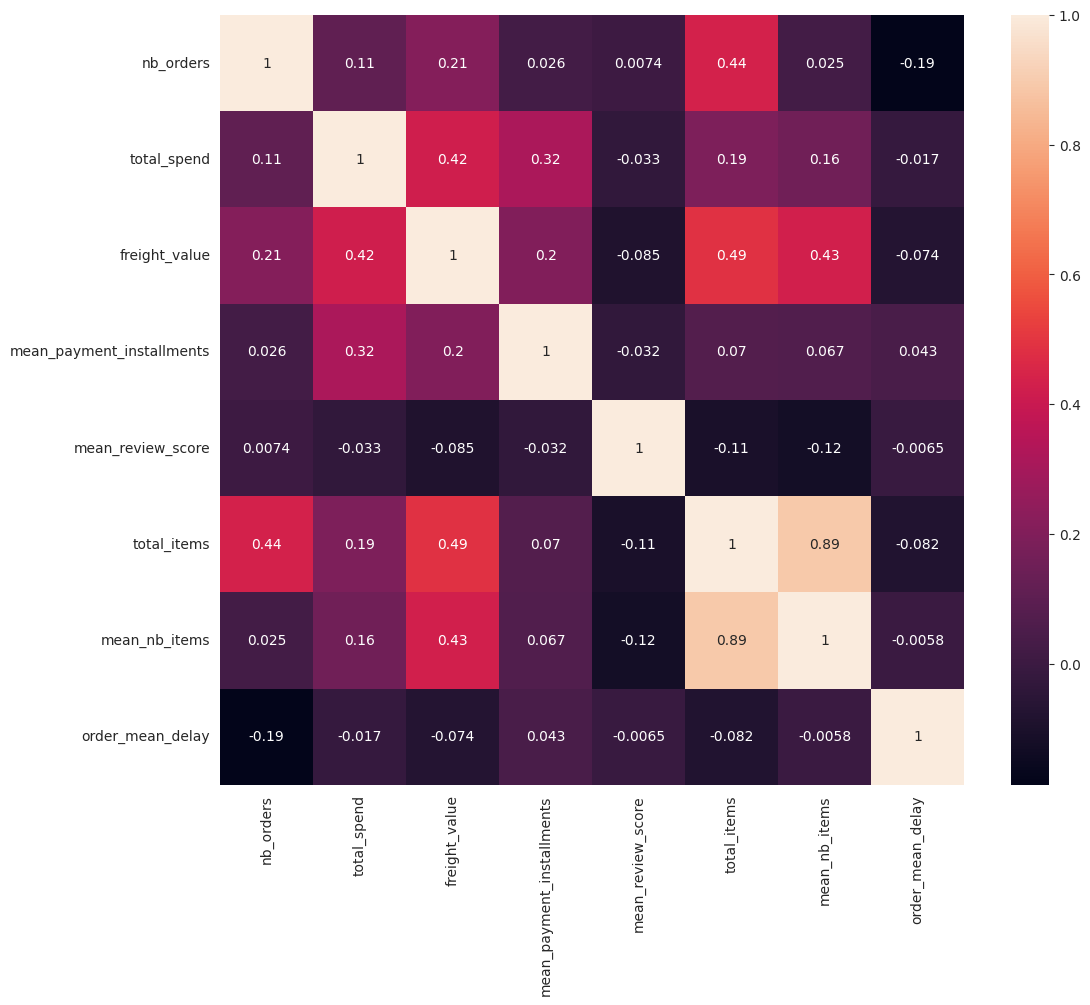

In [ ]:
corr(data)

On remarque que le prix total est très fortement corrélé au prix moyen par commande (idem pour le nombre d'articles moyen et le nombre d'articles total). Cela est dû au fait que la majorité des clients n'ont commandé qu'une seule fois. Cette variable sera donc moins corrélée au fil du temps.


In [ ]:
data.to_csv("/content/drive/MyDrive/OC: Data Science/Datasets/Projet 5/olist-customers-segmentation.csv", index=False)